In [1]:
import cv2

import tensorflow as tf
import os
import random
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
 
import matplotlib.pyplot as plt

from PIL import Image, ImageOps


In [2]:
def calc_hist(image):
 
  hist = np.zeros(256)

  

  img_copy = image.copy() 
  
  img_list = list(img_copy.flatten())
  
  for p in img_list:
    hist[p] += 1
 

  return hist

In [3]:
def calc_cdf(img):
    hist = calc_hist(img)
    n = np.sum(hist)
    hist_normal = hist / n
    cdf = np.cumsum(hist_normal)
    return cdf

In [4]:
def CLAHE(img, const):
    hist = calc_hist(img)
    
    n = np.sum(hist)
    hist_normal = hist / n

    output_image=img.copy()
    
    
    hist_new = np.zeros(256,dtype=float)
    
    max = hist_normal.max()
    
    for p in range(0,256):

        if hist_normal[p] > const*max:
            hist_new[p] =  hist_normal[p] - const*max
            hist_normal[p] = const *max
    
    mean = np.mean(hist_new)

    hist_normal += mean

    cdf_normal = np.cumsum(hist_normal)
    transform_map = np.floor(255 * cdf_normal).astype(np.uint8)
    
    img_list_ = list(output_image.flatten())
    eq_img_list_ = [transform_map[p] for p in img_list_]

    output_image = np.reshape(np.asarray(eq_img_list_), output_image.shape)


    return output_image

In [5]:
IMG_WIDTH = 120
IMG_HEIGHT = 120
IMG_CHANNELS = 1


# model = tf.keras.models.Sequential([

#     tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)),
#     # tf.keras.layers.Lambda(lambda x: x / 255),

#     tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)),


#     tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)),


#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dense(256),
#     tf.keras.layers.Dense(256)
    
# ])

# first layer
# model = tf.keras.models.Sequential()
# model.add(layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)))
# model.add(layers.Lambda(lambda x: x / 255))
# model.add(layers.Conv2D(16, (3,3), padding='same', activation = 'relu'))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))

# # second layer
# model.add(layers.Conv2D(32, (3,3), padding='same',activation='relu'))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# # third layer
# model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))
# model.add(layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))

# # flatten
# model.add(layers.Flatten())

# # FCL
# model.add(layers.Dense(256,input_shape=[256], activation = 'relu'))
# model.add(layers.Dense(256, input_shape=[256]))


input = layers.Input(((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)))
normalize = layers.Lambda(lambda x: x/ 255)(input)

## first layer
c1 = layers.Conv2D(16, (3,3), padding='same')(normalize)
b1 = layers.BatchNormalization()(c1)
r1 = layers.ReLU()(b1)
p1 = layers.MaxPooling2D(pool_size=(4,4), strides=(4,4))(r1)

## second layer
c2 = layers.Conv2D(32, (3,3), padding='same')(p1)
b2 = layers.BatchNormalization()(c2)
r2 = layers.ReLU()(b2)
p2 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(r2)

## third layer
c3 = layers.Conv2D(64, (3,3), padding='same')(p2)
b3 = layers.BatchNormalization()(c3)
r3 = layers.ReLU()(b3)
p3 = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(r3)

## flatten layer
flatten = layers.Flatten()(p3)

## FCLs
fc1 = layers.Dense(256, activation = 'relu')(flatten)
fc2 = layers.Dense(256)(fc1)

model = Model(inputs=input, outputs = fc2)




model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 120, 120, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 120, 120, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                           

In [6]:
IMG_SIZE = 120

def load_images_from_folder(folder):
    x = []
    y = []
    for filename in tqdm(os.listdir(folder)):
        image = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
        
        
        x.append(image)
        y.append(calc_cdf(image))
            
    return x,y

In [7]:
X,Y = load_images_from_folder('natural_images/cat/')


100%|██████████| 885/885 [00:03<00:00, 222.75it/s]


In [8]:
x = np.array(X)
y = np.array(Y, np.float64)


In [9]:
x = np.expand_dims(x, axis=3)

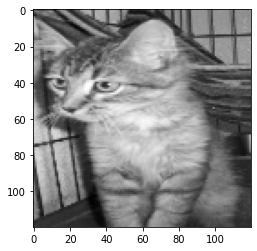

In [10]:
plt.imshow(x[0], cmap='gray')

In [11]:
#compiling model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [12]:
history = model.fit(x,y, epochs=50, validation_split=0.2)

Epoch 1/50
23/23 [==============================] - 4s 162ms/step - loss: 0.1555 - accuracy: 0.0155 - val_loss: 0.3081 - val_accuracy: 0.0056
Epoch 2/50
23/23 [==============================] - 3s 151ms/step - loss: 0.0255 - accuracy: 0.0198 - val_loss: 0.1622 - val_accuracy: 0.0169
Epoch 3/50
23/23 [==============================] - 4s 158ms/step - loss: 0.0158 - accuracy: 0.0438 - val_loss: 0.1178 - val_accuracy: 0.0226
Epoch 4/50
23/23 [==============================] - 3s 152ms/step - loss: 0.0132 - accuracy: 0.0424 - val_loss: 0.0485 - val_accuracy: 0.0113
Epoch 5/50
23/23 [==============================] - 3s 152ms/step - loss: 0.0091 - accuracy: 0.0523 - val_loss: 0.0327 - val_accuracy: 0.0169
Epoch 6/50
23/23 [==============================] - 3s 151ms/step - loss: 0.0076 - accuracy: 0.0607 - val_loss: 0.0250 - val_accuracy: 0.0169
Epoch 7/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0070 - accuracy: 0.0593 - val_loss: 0.0203 - val_accuracy: 0.0169
Epoch 

In [13]:
img = cv2.imread('natural_images/dog/dog_0001.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img,axis=3)
pred= model.predict(img)

1/1 [==============================] - 0s 122ms/step


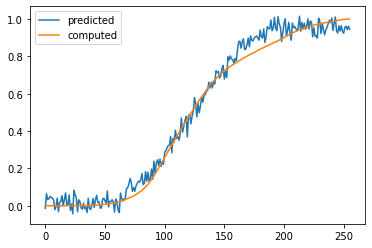

In [24]:
plt.plot(pred[0], label = 'predicted')
plt.plot(calc_cdf(img), label = 'computed')
plt.legend()


In [15]:
pred[0].max()


1.0151224

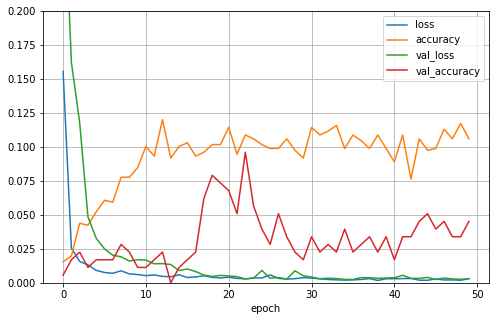

In [16]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel('epoch')
plt.grid(True)
plt.gca().set_ylim(0,0.2)
plt.show()

In [17]:
!mkdir -p saved_model

A subdirectory or file -p already exists.
Error occurred while processing: -p.


In [18]:
model.save('./saved_model/my_model')

INFO:tensorflow:Assets written to: ./saved_model/my_model\assets


INFO:tensorflow:Assets written to: ./saved_model/my_model\assets


In [19]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 120, 120, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 120, 120, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                           

1/1 [==============================] - 0s 89ms/step


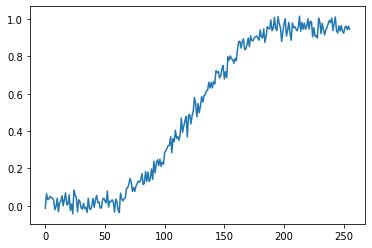

In [20]:
plt.plot(new_model.predict(img)[0])